In [ ]:
!pip install pypdfium2
!sudo apt install tesseract-ocr
!sudo apt-get install tesseract-ocr-deu
!sudo apt-get install tesseract-ocr-frk
!sudo apt-get install tesseract-ocr-fra
!pip install pytesseract
!pip install --upgrade pymupdf
!pip install PyPDF2
!pip install ocrmypdf
!apt-get install -y ghostscript

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 22.8 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 16s (303 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is in

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 libgs9 libgs9-common libidn12 libijs-0.35
  libjbig2dec0 poppler-data
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre ghostscript-x poppler-utils
  fonts-japanese-mincho | fonts-ipafont-mincho fonts-japanese-gothic | fonts-ipafont-gothic
  fonts-arphic-ukai fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript libgs9 libgs9-common libidn12
  libijs-0.35 libjbig2dec0 poppler-data
0 upgraded, 10 newly installed, 0 to remove and 45 not upgraded.
Need to get 16.7 MB of archives.
After this operation, 63.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-droid-fallback all 1:6.0.1r16-1.1build1 [1,805 kB]
Ge

In [ ]:
import pypdfium2 as pdfium
import pytesseract
import shutil
import os
import random
try:
 from PIL import Image
except ImportError:
 import Image
import sys, fitz
import glob
import PyPDF2
import ocrmypdf
import cv2
from google.colab.patches import cv2_imshow
import math

# OCR for outputting text files

If I'm using the text file for translation later, I usually crop off the book/chapter title and/or page numbers by selecting the margins accordingly.

## PDF, single-column, standard font

This section of code deals with a PDF file that is actually a PDF file (not a collection of *images* of texts). The PDF file has to be single-column and use standard font (for example, it can't be Fraktur).

- Input: A real PDF file
- Output:
  - .txt file with line breaks following the PDF file.
  - .txt file with no line breaks other than natural paragraph breaks.

In [ ]:
# ----------------------- SET UP START -------------------------

# the output file, name it the way you like
output_file_name = "test"

# the first page of the document
start_page = 76

# the source PDF file
file_to_read = "/content/Milhet-Fontarabie 1860.pdf"

# ----------------------- SET UP END -------------------------

output_name = output_file_name + ".txt"
f_output = open(output_name, "w")

output_line_name = output_file_name + "_line.txt"
f_output_line = open(output_line_name, "w")

pdf = pdfium.PdfDocument(file_to_read)
version = pdf.get_version()  # get the PDF standard version
n_pages = len(pdf)  # get the number of pages in the document

In [ ]:
# ----------------------- SET UP START -------------------------

# Manually select the margins. Does it look right?
top = 105
bottom = 50

# the number of pages you want to sample
sample_page = 2

# ----------------------- SET UP END -------------------------

page = pdf[sample_page]  # load a page
width, height = page.get_size()
textpage = page.get_textpage()
text_part = textpage.get_text_bounded(bottom=bottom, top=height-top)
print(text_part)

In [ ]:
# Write the extracted text into the text file
for page_num in range(1, n_pages):
    page = pdf[page_num]  # load a page
    textpage = page.get_textpage()
    text_part = textpage.get_text_bounded(bottom=bottom, top=height-top)

    page = "Page " + str(start_page+page_num)
    f_output_line.write(page)
    f_output_line.write("\n\n")
    f_output_line.write(text_part)
    f_output_line.write("\n\n\n")

    # get rid of line
    text_part = text_part.replace("\r\n", " ")

    f_output.write(page)
    f_output.write("\n\n")
    f_output.write(text_part)
    f_output.write("\n\n\n")

f_output.close()
f_output_line.close()

## Image, single-column, standard font

This section can take a PDF file that is a collection of images of texts and transribe it into text files. The PDF file has to be single-column and use standard font (for example, it can't be Fraktur).

- Input: A PDF file of images of texts.
- Output:
  - .txt file with line breaks following the PDF file.
  - .txt file with no line breaks other than natural paragraph breaks.

In [ ]:
# ----------------------- SET UP START -------------------------

# set the output file, name it the way you like
output_file_name = "part4"

# set the first page of the document
start_page = 361

# set the source PDF file
file_to_read = "/content/gottberg_unyamwesi_part4.pdf"

# set the directory you will store the intermediate images in
# this directory will be created
images_dest = "/content/ocr_part4/"

# set the language
lang = "deu"    # "fra" or "deu"

# ----------------------- SET UP END -------------------------

output_name = output_file_name + ".txt"
f_output = open(output_name, "w")

output_line_name = output_file_name + "_line.txt"
f_output_line = open(output_line_name, "w")

mode = 0o666
os.mkdir(images_dest, mode)

In [ ]:
# ----------------------- SET UP START -------------------------

# Select the rectangle in the image, check the image directory
left = 55  # start
top = 84    # start
right = 570   # stop
bottom = 700    # stop

# the number of pages you want to sample
page_until = 50

# the enhance factor
zoom = 2

# ----------------------- SET UP END -------------------------

clip = fitz.Rect(left, top, right, bottom)
doc = fitz.open(file_to_read)  # open document
cur_page = start_page
i = 0

while i < page_until:
    page = doc[i]
    zoom_x = zoom  # horizontal zoom
    zoom_y = zoom  # vertical zoom
    mat = fitz.Matrix(zoom_x, zoom_y)  # zoom factor 2 in each dimension
    rect = page.rect  # the page rectangle

    # set rectangle
    pix = page.get_pixmap(matrix=mat, clip=clip)  # use 'mat' instead of the identity matrix
    padded_cur_page = "{:03d}".format(cur_page)
    save_dest = images_dest + padded_cur_page + ".png"
    pix.save(save_dest)  # store image as a PNG
    cur_page += 1
    i += 1

In [ ]:
# read the pdf and convert pages into images
cur_page = start_page
for page in doc:  # iterate through the pages
    zoom_x = zoom  # horizontal zoom
    zoom_y = zoom  # vertical zoom
    mat = fitz.Matrix(zoom_x, zoom_y)  # zoom factor 2 in each dimension
    rect = page.rect  # the page rectangle
    clip = clip  # the area we want  left (start) - top (start) - right (stop) - bottom (stop)
    pix = page.get_pixmap(matrix=mat, clip=clip)  # use 'mat' instead of the identity matrix
    padded_cur_page = "{:03d}".format(cur_page)
    save_dest = images_dest + padded_cur_page + ".png"
    pix.save(save_dest)  # store image as a PNG
    cur_page += 1


# extract the texts of the images
filelist = glob.glob(os.path.join(images_dest, '*.png'))

cur_page = start_page
for infile in sorted(filelist):
    text = pytesseract.image_to_string(Image.open(infile), lang=lang)
    page = "Page " + str(cur_page)

    f_output_line.write(page)
    f_output_line.write("\n\n")
    f_output_line.write(text)
    f_output_line.write("\n\n\n")

    # get rid of line
    for i in range(len(text)-1):
        if text[i] == "\n" and text[i+1] != "\n":
            text = text.replace(text[i], " ")

    f_output.write(page)
    f_output.write("\n\n")
    f_output.write(text)
    f_output.write("\n\n\n")

    cur_page += 1

f_output.close()
f_output_line.close()

## Image, two-column, standard font

This section can take a PDF file that is a collection of images of texts and transribe it into text files. The PDF file can be two-column. It has to use standard font (for example, it can't be Fraktur).

- Input: A PDF file of images of texts.
- Output:
  - .txt file with line breaks following the PDF file.
  - .txt file with no line breaks other than natural paragraph breaks.


In [ ]:
# ----------------------- SET UP START -------------------------

# set the output file, name it the way you like
output_file_name = "test"

# set the first page of the document
start_page = 1

# set the source PDF file
file_to_read = "/content/scan01.pdf"

# set the directory you will store the intermediate images in
# this directory will be created
images_dest = "/content/test/"

# set the language
lang = "deu"    # "fra" or "deu"

# ----------------------- SET UP END -------------------------

output_name = output_file_name + ".txt"
f_output = open(output_name, "w")

output_line_name = output_file_name + "_line.txt"
f_output_line = open(output_line_name, "w")

mode = 0o666
os.mkdir(images_dest, mode)

In [ ]:
# ----------------------- SET UP START -------------------------

# Select the rectangle in the image, check the image directory
left = 30   # start
top = 30    # start
right = 580   # stop
bottom = 670    # stop

# the number of pages you want to sample
page_until = 10

# the enhance factor
zoom = 2

# ----------------------- SET UP END -------------------------

clip = fitz.Rect(left, top, right, bottom)
doc = fitz.open(file_to_read)  # open document
cur_page = start_page
i = 0

while i < page_until:
    page = doc[i]
    zoom_x = zoom  # horizontal zoom
    zoom_y = zoom  # vertical zoom
    mat = fitz.Matrix(zoom_x, zoom_y)  # zoom factor 2 in each dimension
    rect = page.rect  # the page rectangle

    # set rectangle
    pix = page.get_pixmap(matrix=mat, clip=clip)  # use 'mat' instead of the identity matrix
    padded_cur_page = "{:03d}".format(cur_page)
    save_dest = images_dest + padded_cur_page + ".png"
    pix.save(save_dest)  # store image as a PNG
    cur_page += 1
    i += 1

In [ ]:
# read the pdf and convert pages into images
cur_page = start_page
for page in doc:  # iterate through the pages
    zoom_x = zoom  # horizontal zoom
    zoom_y = zoom  # vertical zoom
    mat = fitz.Matrix(zoom_x, zoom_y)  # zoom factor 2 in each dimension
    rect = page.rect  # the page rectangle
    clip = clip  # the area we want  left (start) - top (start) - right (stop) - bottom (stop)
    pix = page.get_pixmap(matrix=mat, clip=clip)  # use 'mat' instead of the identity matrix
    padded_cur_page = "{:03d}".format(cur_page)
    save_dest = images_dest + padded_cur_page + ".png"
    pix.save(save_dest)  # store image as a PNG
    cur_page += 1


# extract the texts of the images
filelist = glob.glob(os.path.join(images_dest, '*.png'))

cur_page = start_page
for infile in sorted(filelist):
    text = pytesseract.image_to_string(Image.open(infile), lang=lang, config='--psm 1')
    page = "Page " + str(cur_page)

    f_output_line.write(page)
    f_output_line.write("\n\n")
    f_output_line.write(text)
    f_output_line.write("\n\n\n")

    # get rid of line
    for i in range(len(text)-1):
        if text[i] == "\n" and text[i+1] != "\n":
            text = text.replace(text[i], " ")

    f_output.write(page)
    f_output.write("\n\n")
    f_output.write(text)
    f_output.write("\n\n\n")

    cur_page += 1

f_output.close()
f_output_line.close()

## Image, two-column, German Fraktur

Unfortunately, Open-source Python libraries for OCR at the moment suck at recognizing non-standard font, like Fraktur. The best platform to recognize Fraktur that I have found is [Transkribus](https://www.transkribus.org/). However, Transkribus does not work with two-column, so here I use Python to crop each page into two pages, one for each column. If you have a single-column document in Fraktur, you can go directly to Transkribus. Note that the output file here might need some post-processing manually (like whiteing out some texts).

- Input: A PDF file of images of texts, two-column, non-standard font.
- Output: A PDF file of pages, each page is a column.



In [ ]:
# ----------------------- SET UP START -------------------------

# the first page of the document
start_page = 65

# the source PDF file
file_to_read = "/content/2. Reichard, ‘Die bedetung von Tabora'.pdf"

# the directory you will store the intermediate images in
images_dest = "/content/source2_images/"

# the output file name, without the extension
file_output_name = "source2"

# ----------------------- SET UP END -------------------------

mode = 0o666
os.mkdir(images_dest, mode)

In [ ]:
# ----------------------- SET UP START -------------------------

# Select the rectangle in the image, check the image directory

# the left column
left_l = 30   # start
top_l = 30    # start
right_l = 580   # stop
bottom_l = 670    # stop

# the right column
left_r = 30   # start
top_r = 30    # start
right_r = 580   # stop
bottom_r = 670    # stop

# the number of pages you want to sample
page_until = 10

# the enhance factor
zoom = 2

# ----------------------- SET UP END -------------------------

clip_l = fitz.Rect(left_l, top_l, right_l, bottom_l)
clip_r = fitz.Rect(left_r, top_r, right_r, bottom_r)

doc = fitz.open(file_to_read)  # open document
cur_page = start_page
i = 0
while i < 10:
    page = doc[i]
    zoom_x = zoom  # horizontal zoom
    zoom_y = zoom  # vertical zoom
    mat = fitz.Matrix(zoom_x, zoom_y)  # zoom factor 2 in each dimension
    rect = page.rect  # the page rectangle

    # left half
    # set rectangle
    pix = page.get_pixmap(matrix=mat, clip=clip_l)  # use 'mat' instead of the identity matrix

    padded_cur_page = "{:03d}".format(cur_page)
    save_dest = images_dest + padded_cur_page + "_1" + ".png"
    pix.save(save_dest)  # store image as a PNG


    # right half
    # set rectangle
    pix = page.get_pixmap(matrix=mat, clip=clip_r)  # use 'mat' instead of the identity matrix

    padded_cur_page = "{:03d}".format(cur_page)
    save_dest = images_dest + padded_cur_page + "_2" + ".png"
    pix.save(save_dest)  # store image as a PNG

    cur_page += 1
    i += 1

In [ ]:
# read the pdf and convert pages into images
cur_page = start_page
for page in doc:  # iterate through the pages
    zoom_x = zoom  # horizontal zoom
    zoom_y = zoom  # vertical zoom
    mat = fitz.Matrix(zoom_x, zoom_y)  # zoom factor 2 in each dimension
    rect = page.rect  # the page rectangle

    # left column
    pix = page.get_pixmap(matrix=mat, clip=clip_l)  # use 'mat' instead of the identity matrix

    padded_cur_page = "{:03d}".format(cur_page)
    save_dest = images_dest + padded_cur_page + "_1" + ".png"
    pix.save(save_dest)  # store image as a PNG


    # right column
    pix = page.get_pixmap(matrix=mat, clip=clip_r)  # use 'mat' instead of the identity matrix

    padded_cur_page = "{:03d}".format(cur_page)
    save_dest = images_dest + padded_cur_page + "_2" + ".png"
    pix.save(save_dest)  # store image as a PNG

    cur_page += 1


# combine the images into a pdf files
doc = fitz.open()  # PDF with the pictures
imgdir = images_dest  # where the pics are
imglist = os.listdir(imgdir)  # list of them
imglist.sort()
imgcount = len(imglist)  # pic count

for i, f in enumerate(imglist):
    img = fitz.open(os.path.join(imgdir, f))  # open pic as document
    rect = img[0].rect  # pic dimension
    pdfbytes = img.convert_to_pdf()  # make a PDF stream
    img.close()  # no longer needed
    imgPDF = fitz.open("pdf", pdfbytes)  # open stream as PDF
    page = doc.new_page(width = rect.width,  # new page with ...
                       height = rect.height)  # pic dimension
    page.show_pdf_page(rect, imgPDF, 0)  # image fills the page

doc_name = file_output_name + ".pdf"
doc.save(doc_name)

# PDF Processing

## Make PDF searchable

If your PDF file is a collection of images, the texts are likely not searchable. Use the block below to convert it into searchable PDF.

In [ ]:
# ----------------------- SET UP START -------------------------

# PDF source file
file_path = "/content/histoire_des_rois_iv.pdf"

# where you want to save the new searchable PDF
save_path = "/content/histoire_des_rois_iv_searchable.pdf"

# language of the document
lang = "fra"    # "fra" or "deu"

# ----------------------- SET UP END -------------------------

ocrmypdf.ocr(file_path, save_path, rotate_pages=True, \
             language=lang, deskew=True, force_ocr=True)

Output()

Output()

Output()

ERROR:ocrmypdf._exec.ghostscript:GPL Ghostscript 9.55.0 (2021-09-27)
Copyright (C) 2021 Artifex Software, Inc.  All rights reserved.
This software is supplied under the GNU AGPLv3 and comes with NO WARRANTY:
see the file COPYING for details.
Processing pages 1 through 345.
Page 1
Page 2
Page 3
Page 4
Page 5
Page 6
Page 7
Page 8
Page 9
Page 10
Page 11
Page 12
Page 13
Page 14
Page 15
Page 16
Page 17
Page 18
Page 19
Page 20
Page 21
Page 22
Page 23
Page 24
Page 25
Page 26
Page 27
Page 28
Page 29
Page 30
Page 31
Page 32
Page 33
Page 34
Page 35
Page 36
Page 37
Page 38
Page 39
Page 40
Page 41
Page 42
Page 43
Page 44
Page 45
Page 46
Page 47
Page 48
Page 49
Page 50
Page 51
Page 52
Page 53
Page 54
Page 55
Page 56
Page 57
Page 58
Page 59
Page 60
Page 61
Page 62
Page 63
Page 64
Page 65
Page 66
Page 67
Page 68
Page 69
Page 70
Page 71
Page 72
Page 73
Page 74
Page 75
Page 76
Page 77
Page 78
Page 79
Page 80
Page 81
Page 82
Page 83
                 Output may be incorrect.

   
ERROR:ocrmypdf._exec.gho

Output()

Output()

Output()

Output()

<ExitCode.ok: 0>

## Combine images into a PDF file

Store the images you want to combine into a PDF in a directory. The image files should be named in a way that has order (for example: `000.png`, `001.png`, `002.png`, ...).

In [ ]:
# ----------------------- SET UP START -------------------------

# the source images directory
images_source_dir = "/content/francis_papers_contrasted_images/"

# the directory you will store the intermediate images in
# this directory will be created
images_mid_dir = "/content/francis_papers_inter_images2/"

# the output file name, without the extension
file_output_name = "francis_papers_contrasted_enhanced"

# ----------------------- SET UP END -------------------------
mode = 0o666
os.mkdir(images_mid_dir, mode)

In [ ]:
# ----------------------- SET UP START -------------------------

# Select the rectangle in the image, check the images_mid_dir
left = 0   # start
top = 0    # start
right = 1000   # stop
bottom = 1000    # stop

# the enhance factor
zoom = 2

# ----------------------- SET UP END -------------------------

# Define the list of images
imglist = os.listdir(images_source_dir)
imglist.sort()

clip = fitz.Rect(left, top, right, bottom)

image_path = images_source_dir + imglist[0]
doc = fitz.open(image_path)  # open document

page = doc[0]
mat = fitz.Matrix(zoom, zoom)  # zoom factor in each dimension
rect = page.rect  # the page rectangle

# set rectangle
pix = page.get_pixmap(matrix=mat, clip=clip)  # use 'mat' instead of the identity matrix
save_dest = images_mid_dir + imglist[0]
pix.save(save_dest)  # store image as a PNG

In [ ]:
# crop every page
for image in imglist:
    image_path = images_source_dir + image
    doc = fitz.open(image_path)  # open document

    page = doc[0]
    mat = fitz.Matrix(zoom, zoom)  # zoom factor in each dimension
    rect = page.rect  # the page rectangle

    # set rectangle
    pix = page.get_pixmap(matrix=mat, clip=clip)  # use 'mat' instead of the identity matrix
    save_dest = images_mid_dir + image
    pix.save(save_dest)  # store image as a PNG


# create a PDF document
doc = fitz.open()  # PDF with the pictures
imglist = os.listdir(images_mid_dir)
imglist.sort()
imgcount = len(imglist)  # pic count

for i, f in enumerate(imglist):
    img = fitz.open(os.path.join(images_mid_dir, f))  # open pic as document
    rect = img[0].rect  # pic dimension
    pdfbytes = img.convert_to_pdf()  # make a PDF stream
    img.close()  # no longer needed
    imgPDF = fitz.open("pdf", pdfbytes)  # open stream as PDF
    page = doc.new_page(width = rect.width,  # new page with ...
                       height = rect.height)  # pic dimension
    page.show_pdf_page(rect, imgPDF, 0)  # image fills the page

doc_name = file_output_name + ".pdf"
doc.save(doc_name)

## Combine multiple PDFs into a PDF

Store the PDFs you want to combine into a PDF in a directory. The PDF files should be named in a way that has order (for example: `book_part1.pdf`, `book_part2.pdf`, `book_part3.pdf`, ...).

In [ ]:
# ----------------------- SET UP START -------------------------

# The source directory that contains the source PDF files
input_dir = '/content/part4/'

# The output file name without extension
output_file_name = "gottberg_unyamwesi_part4"

# ----------------------- SET UP END -------------------------

# List of PDF files to be merged
pdf_files = os.listdir(input_dir)
pdf_files.sort()

# Create a PdfFileMerger object
merger = PyPDF2.PdfMerger()

# Loop through all the PDF files and append them to the merger
for pdf in pdf_files:
    path = os.path.join(input_dir, pdf)
    merger.append(path)

# Write out the merged PDF
output_file = output_file_name + ".pdf"
with open(output_file, 'wb') as output_pdf:
    merger.write(output_pdf)

## Splitting PDF into n smaller PDF files

The output smaller PDFs are named `original_PDF_name_part_i`.pdf, where i is variable.

In [ ]:
# ----------------------- SET UP START -------------------------

# The source PDF file
input_pdf = '/content/francis_papers_contrasted_enhanced.pdf'

# The output directory that will be created and will store the split PDF files
output_dir = "/content/francis_papers_split/"

# Number of output files
n = 2

# ----------------------- SET UP END -------------------------

mode = 0o666
os.mkdir(output_dir, mode)

# Open the input PDF file
with open(input_pdf, 'rb') as pdf_file:
    pdf_reader = PyPDF2.PdfReader(pdf_file)
    num_pages = len(pdf_reader.pages)

    # Calculate the number of pages per file
    pages_per_file = math.ceil(num_pages / n)

    # Loop to create each output PDF
    for i in range(n):
        pdf_writer = PyPDF2.PdfWriter()

        start_page = i * pages_per_file
        end_page = min(start_page + pages_per_file, num_pages)

        for page_number in range(start_page, end_page):
            pdf_writer.add_page(pdf_reader.pages[page_number])

        output_filename = f"{output_dir}part_{i + 1}.pdf"
        with open(output_filename, 'wb') as output_pdf:
            pdf_writer.write(output_pdf)

# Image processing

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

## Change the contrast and brightness

The code here can take a directory of images and process them in a batch.

In [ ]:
# ----------------------- SET UP START -------------------------

# the source images directory
images_source_dir = "/content/francis_papers_inter_images/"

# the directory you will store the processed images in
# it will be created
images_processed_dir = "/content/francis_papers_contrasted_images/"

# ----------------------- SET UP END -------------------------
mode = 0o666
os.mkdir(images_processed_dir, mode)

In [ ]:
# ----------------------- SET UP START -------------------------
# test a few pages to see if this is your desired alpha and beta values

# alpha value (contrast)
alpha = 2

# beta value (brightness)
beta = -300

# the number of pages you want to test
page_until = 10

# ----------------------- SET UP END -------------------------
imglist = os.listdir(images_source_dir)
imglist.sort()

count = 0
for image_name in imglist:
    image_path = images_source_dir + image_name
    image = cv2.imread(image_path)
    adjusted_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    save_path = images_processed_dir + image_name
    cv2.imwrite(save_path, adjusted_image)
    count += 1
    if count == page_until:
        break

In [ ]:
# process every page
for image_name in imglist:
    image_path = images_source_dir + image_name
    image = cv2.imread(image_path)
    adjusted_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    save_path = images_processed_dir + image_name
    cv2.imwrite(save_path, adjusted_image)

## scribble area

This section is not organized. I am just testing code here.

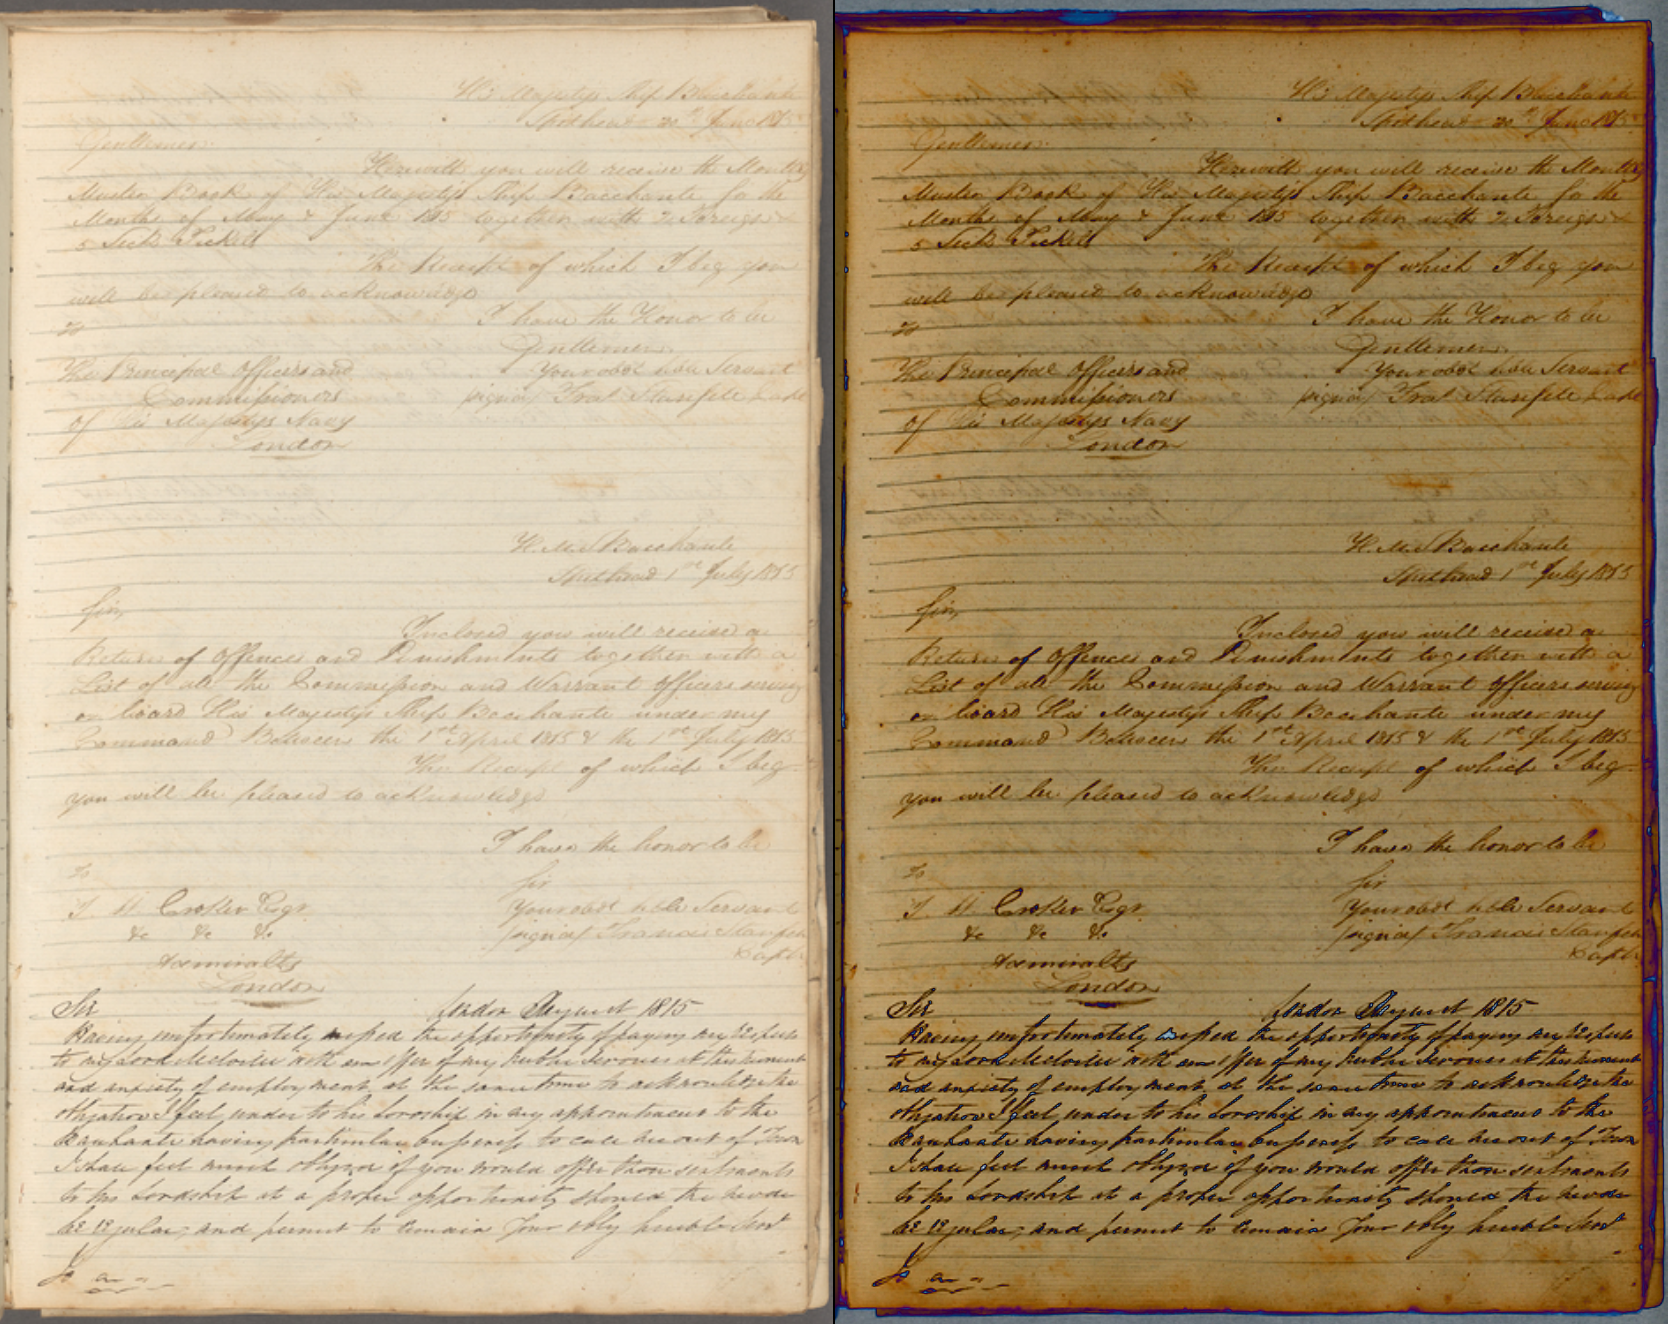

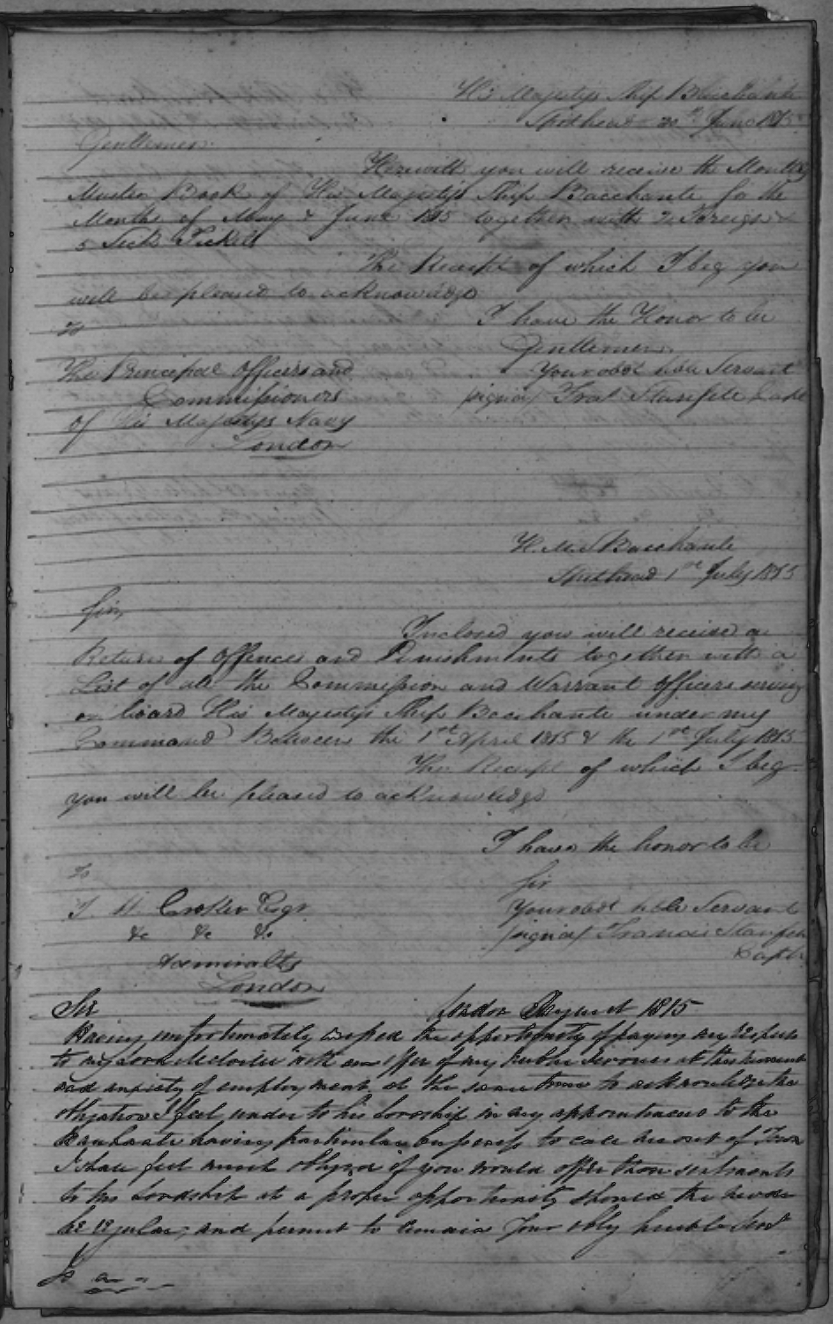

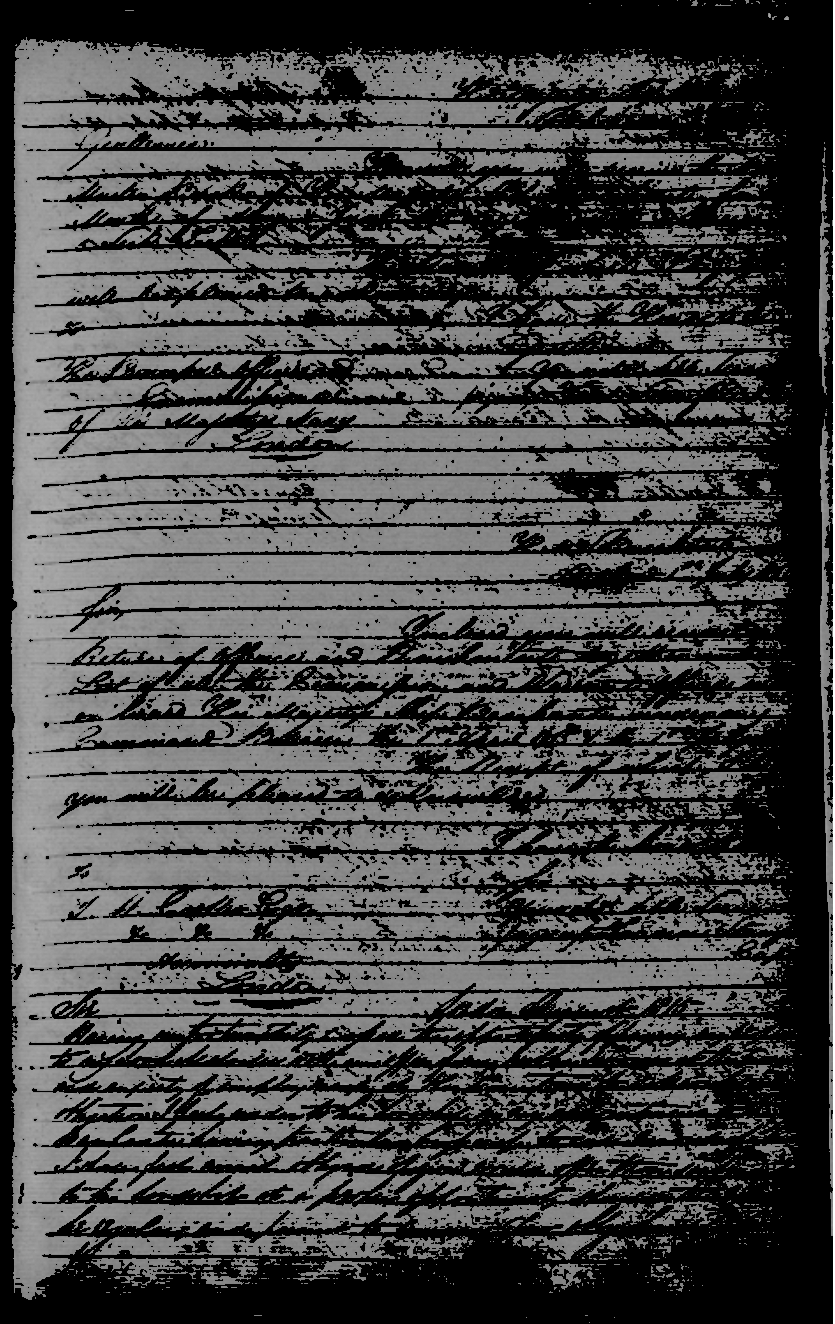

In [ ]:
image = cv2.imread('/content/099.png')
# cv2_imshow(image)
adjusted_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
# cv2_imshow(adjusted_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
cv2.imwrite('/content/099_contrast.png', adjusted_image)
combined_image = np.hstack((image, adjusted_image))
cv2_imshow(combined_image)

grayscale_image = cv2.cvtColor(adjusted_image, cv2.COLOR_BGR2GRAY)
cv2_imshow(grayscale_image)

ret, to_zero_image = cv.threshold(grayscale_image, 127,255,cv.THRESH_TOZERO)
cv2_imshow(to_zero_image)


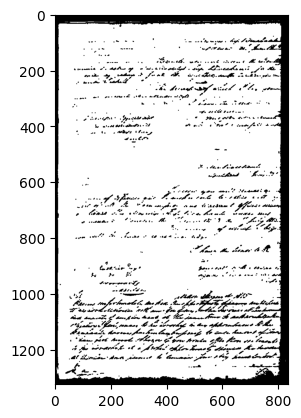

In [ ]:
import cv2
from matplotlib import pyplot as plt
# import pytesseract

# Read the image
image = cv2.imread('/content/099.png')

# Convert to grayscale
grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply thresholding
threshold, binary_image = cv2.threshold(grayscale_image, 200, 255, cv2.THRESH_BINARY)

# Apply morphological operations
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
morphological_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)

# combined_image = np.hstack((image, morphological_image))
# cv2_imshow(combined_image)

# Display the processed image
plt.imshow(morphological_image, cmap='gray')
plt.show()

# # Optionally, apply OCR to extract text
# text = pytesseract.image_to_string(morphological_image)
# print(text)

In [ ]:
# edge detection
image = cv2.imread('/content/test1.png')
# ratio = image.shape[0] / 500.0
# orig = image.copy()
# image = imutils.resize(image, height = 500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# gray = cv2.bilateralFilter(gray, 11, 17, 17)  # 11  //TODO 11 FRO OFFLINE MAY NEED TO TUNE TO 5 FOR ONLINE
# gray = cv2.medianBlur(gray, 5)
edged = cv2.Canny(gray, 30, 400)

In [ ]:
cv2.imwrite('/content/test1result.png', gray)

True

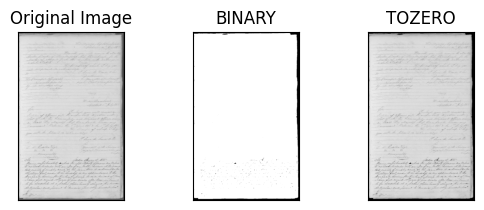

True

In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

img = cv.imread('/content/099.png', cv.IMREAD_GRAYSCALE)

ret,thresh1 = cv.threshold(img,127,255,cv.THRESH_BINARY)
# ret,thresh2 = cv.threshold(img,127,255,cv.THRESH_BINARY_INV)
# ret,thresh3 = cv.threshold(img,127,255,cv.THRESH_TRUNC)
ret,thresh4 = cv.threshold(img,127,255,cv.THRESH_TOZERO)
# ret,thresh5 = cv.threshold(img,127,255,cv.THRESH_TOZERO_INV)

# titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
titles = ['Original Image','BINARY','TOZERO']
# images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]
images = [img, thresh1, thresh4]

for i in range(3):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray',vmin=0,vmax=255)
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.show()
cv.imwrite('/content/test_binary.png', images[1])
cv.imwrite('/content/test_tozero.png', images[2])

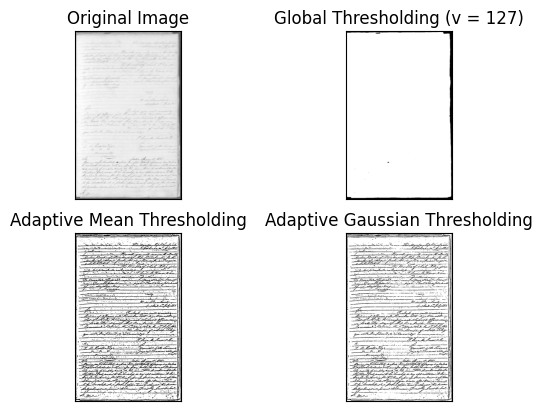

True

In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

img = cv.imread('/content/099.png', cv.IMREAD_GRAYSCALE)
img = cv.medianBlur(img,5)

ret,th1 = cv.threshold(img,127,255,cv.THRESH_BINARY)
th2 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_MEAN_C, \
                           cv.THRESH_BINARY,11,2)
th3 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, \
                           cv.THRESH_BINARY,11,2)

titles = ['Original Image', 'Global Thresholding (v = 127)',\
          'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img, th1, th2, th3]

for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

cv.imwrite('/content/test_adap_gau.png', images[3])

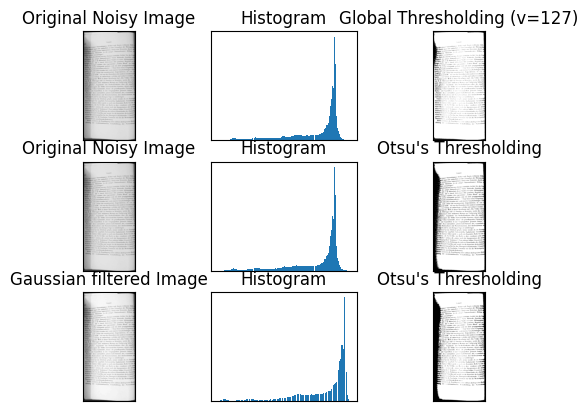

In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

img = cv.imread('/content/test1.png', cv.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"

# global thresholding
ret1,th1 = cv.threshold(img,127,255,cv.THRESH_BINARY)

# Otsu's thresholding
ret2,th2 = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

# Otsu's thresholding after Gaussian filtering
blur = cv.GaussianBlur(img,(5,5),0)
ret3,th3 = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

# plot all the images and their histograms
images = [img, 0, th1,
 img, 0, th2,
 blur, 0, th3]
titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)',
 'Original Noisy Image','Histogram',"Otsu's Thresholding",
 'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]

for i in range(3):
 plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
 plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
 plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
 plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
 plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
 plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
import cv2

image = cv2.imread('/content/test1result.png')
image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
se=cv2.getStructuringElement(cv2.MORPH_RECT , (8,8))
bg=cv2.morphologyEx(image, cv2.MORPH_DILATE, se)
out_gray=cv2.divide(image, bg, scale=255)
out_binary=cv2.threshold(out_gray, 177, 255, cv2.THRESH_OTSU )[1]

# cv2.imshow('binary', out_binary)
cv2.imwrite('binary.png',out_binary)

# cv2.imshow('gray', out_gray)
cv2.imwrite('gray.png',out_gray)

True

In [ ]:
import cv2
import numpy as np

# load image
img = cv2.imread("/content/test1result.png")

# convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# blur
blur = cv2.GaussianBlur(gray, (0,0), sigmaX=33, sigmaY=33)

# divide
divide = cv2.divide(gray, blur, scale=255)

# otsu threshold
thresh = cv2.threshold(divide, 255, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

# apply morphology
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

# write result to disk
cv2.imwrite("division.jpg", divide)
cv2.imwrite("division_threshold.jpg", thresh)
cv2.imwrite("division_morph.jpg", morph)

# # display it
# cv2.imshow("gray", gray)
# cv2.imshow("divide", divide)
# cv2.imshow("thresh", thresh)
# cv2.imshow("morph", morph)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

True